In [1]:
# load libs
from det3.ops import read_pkl
from incdet3.utils.utils import filt_label_by_range
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('font',family='Times New Roman')
plt.rcParams.update({'font.size': 18})

In [38]:
# define global variables
g_info_pkl_path = "/usr/app/data/KITTI/KITTI_infos_val.pkl"
g_valid_range = [0, -32.0, -3, 52.8, 32.0, 1]
g_valid_classes_dict = {
    "old": ["Car", "Pedestrian"],
    "new": ["Cyclist", "Van", "Truck"],
    "all": ["Car", "Pedestrian", "Cyclist", "Van", "Truck"]
}
g_config_dict = {
    "Car": "3d@0.50",
    "Pedestrian": "3d@0.25",
    "Cyclist": "3d@0.25",
    "Van": "3d@0.50",
    "Truck": "3d@0.50",
}
g_mAP_hist_oldtask = {
    "joint training": {"step2": 81.9,
                      "step3": None,
                      "step4": None,
                      "step5": None,
                     },
    "c-kd (mas)": {"step2": 81.9,
                  "step3": None,
                  "step4": None,
                  "step5": 81.8,
                 },
    "c-kd (ewc)": {"step2": 81.9,
                  "step3": None,
                  "step4": None,
                  "step5": None,
                 },
    "kd": {"step2": 81.9,
            "step3": None,
            "step4": None,
            "step5": None,
           },
    "fine-tuning": {"step2": 81.9,
                  "step3": None,
                  "step4": None,
                  "step5": None,
                 },

}
g_case2evalresult = {
    "joint training step3": {
        "old": "/usr/app/incdet3/logs/20201105-expkitti2+seq-evallogs/20201105-expkitti2+seq-B3jointtrainingold-eval/test_results.pkl",
    },
    "joint training step4": {
        "old": "/usr/app/incdet3/logs/20201105-expkitti2+seq-evallogs/20201105-expkitti2+seq-B4jointtrainingold-eval/test_results.pkl",
    },
    "joint training step5": {
        "old": "/usr/app/incdet3/logs/20200817-expkitti2+seq-eval-logs/20200817-expkitti2+seq-B3to5jointtrainingold-eval/test_results.pkl",
    },
    "c-kd (mas) step3": {
        "old": "/usr/app/incdet3/logs/20201105-expkitti2+seq-evallogs/20201105-expkitti2+seq-B3kdmasold-eval/test_results.pkl",
    },
    "c-kd (mas) step4": {
        "old": "/usr/app/incdet3/logs/20201105-expkitti2+seq-evallogs/20201105-expkitti2+seq-B4kdmasold-eval/test_results.pkl",
    },
    "c-kd (ewc) step3": {
        "old": "/usr/app/incdet3/logs/20201105-expkitti2+seq-evallogs/20201105-expkitti2+seq-B3kdewcold-eval/test_results.pkl",
    },
    "c-kd (ewc) step4": {
        "old": "/usr/app/incdet3/logs/20201105-expkitti2+seq-evallogs/20201105-expkitti2+seq-B4kdewcold-eval/test_results.pkl",
    },
    "c-kd (ewc) step5": {
        "old": "/usr/app/incdet3/logs/20200925-expkitti2+seq-evallogs/20200925-expkitti2+seq-B3to5kdewcold-eval/test_results.pkl",
    },
    "kd step3": {
        "old": "/usr/app/incdet3/logs/20201105-expkitti2+seq-evallogs/20201105-expkitti2+seq-B3lwfold-eval/test_results.pkl",
    },
    "kd step4": {
        "old": "/usr/app/incdet3/logs/20201105-expkitti2+seq-evallogs/20201105-expkitti2+seq-B4lwfold-eval/test_results.pkl",
    },
    "kd step5": {
        "old": "/usr/app/incdet3/logs/20200817-expkitti2+seq-eval-logs/20200817-expkitti2+seq-B3to5lwfold-eval/test_results.pkl",
    },
    "fine-tuning step3": {
        "old": "/usr/app/incdet3/logs/20201105-expkitti2+seq-evallogs/20201105-expkitti2+seq-B3finetuningold-eval/test_results.pkl",
    },
    "fine-tuning step4": {
        "old": "/usr/app/incdet3/logs/20201105-expkitti2+seq-evallogs/20201105-expkitti2+seq-B4finetuningold-eval/test_results.pkl",
    },
    "fine-tuning step5": {
        "old": "/usr/app/incdet3/logs/20200817-expkitti2+seq-eval-logs/20200817-expkitti2+seq-B3to5finetuningold-eval/test_results.pkl",
    },
}

In [39]:
# define functions
def compute_acc_dict(info_pkl, valid_range, valid_classes):
    # compute num of cars and num of pedes
    acc_dict = {itm: 0 for itm in valid_classes}
    ## load val pkl
    for itm in info_pkl:
        label = itm['label']
        calib = itm['calib']
        label_ = filt_label_by_range(label, valid_range, calib)
        if len(label_) == 0:
            continue
        has_classes = [obj.type for obj in label_.data]
        has_classes = list(set(has_classes))
        for cls in has_classes:
            if cls in valid_classes:
                acc_dict[cls] += 1
    return acc_dict
    
def compute_mAP(eval_result, acc_dict):
    data = eval_result['detail']
    valid_classes = [itm for itm in acc_dict.keys()]
    calc_map_dict = {itm: None for itm in valid_classes}
    for cls in valid_classes:
        eval_attrib = g_config_dict[cls]
        calc_map_dict[cls] = data[cls][eval_attrib]
    map_val = 0
    for cls in valid_classes:
        mean_ap = sum(calc_map_dict[cls]) / len(calc_map_dict[cls])
        cls_norm = acc_dict[cls] / sum([v for k, v in acc_dict.items()])
        map_val += mean_ap * cls_norm
    return map_val

In [40]:
# fill g_mAP_hist_oldtask
task = "old"
info_pkl_path = g_info_pkl_path
valid_range = g_valid_range
valid_classes = g_valid_classes_dict[task]
case_list = g_case2evalresult.keys()

info_pkl = read_pkl(info_pkl_path)
acc_dict = compute_acc_dict(info_pkl, valid_range, valid_classes)
print(acc_dict)
old_mAP_dict = {}
for case in case_list:
    if g_case2evalresult[case][task] is None:
        continue
    eval_result = read_pkl(g_case2evalresult[case][task])
    old_mAP = compute_mAP(eval_result, acc_dict)
    old_mAP_dict[case] = old_mAP
for k, v in old_mAP_dict.items():
    print(f"{k},{v:.1f}")

for k, v in g_mAP_hist_oldtask.items():
    for kk, vv in v.items():
        if vv is None:
            g_mAP_hist_oldtask[k][kk] = old_mAP_dict[f"{k} {kk}"]
        
for k, v in g_mAP_hist_oldtask.items():
    print("========")
    print(k)
    for kk, vv in v.items():
        print(kk, vv)

{'Car': 3277, 'Pedestrian': 802}
joint training step3,84.1
joint training step4,84.1
joint training step5,83.8
c-kd (mas) step3,82.1
c-kd (mas) step4,82.0
c-kd (ewc) step3,81.5
c-kd (ewc) step4,79.2
c-kd (ewc) step5,79.3
kd step3,78.7
kd step4,74.8
kd step5,67.8
fine-tuning step3,0.0
fine-tuning step4,0.0
fine-tuning step5,0.0
joint training
step2 81.9
step3 84.12679580792471
step4 84.12333068191361
step5 83.80936655958118
c-kd (mas)
step2 81.9
step3 82.13849666138763
step4 82.00972183132917
step5 81.8
c-kd (ewc)
step2 81.9
step3 81.54372911988422
step4 79.21274353039868
step5 79.34553134902167
kd
step2 81.9
step3 78.6858255126042
step4 74.79010468424804
step5 67.77550148094781
fine-tuning
step2 81.9
step3 0.0
step4 0.0
step5 0.0


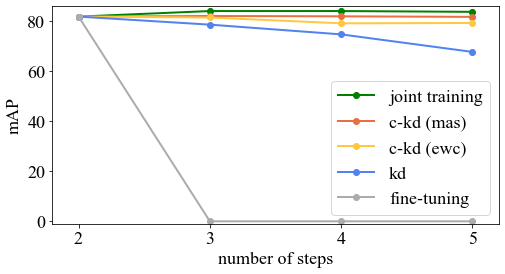

In [41]:
# Plot accuracy curves
plt_case2color = {
    "fine-tuning": (174/255.0,171/255.0, 172/255.0),
    "kd": (82/255.0,130/255.0, 238/255.0),
    "c-kd (mas)": (233/255.0,110/255.0, 64/255.0),
    "c-kd (ewc)": (255/255.0,200/255.0, 64/255.0),
    "joint training": "green"
}
plt.figure(figsize=(8,4))
for k, v in g_mAP_hist_oldtask.items():
    plt_label = k
    plt_x = []
    plt_y = []
    plt_color = None
    for kk, vv in v.items():
        plt_x.append(int(kk[-1]))
        plt_y.append(vv)
    plt.plot(plt_x, plt_y, '-o', label=plt_label, linewidth=2,  color=plt_case2color[plt_label])
    plt.xlim([2-0.2, 5+0.2])
    plt.xticks(plt_x)
plt.ylim([0-1, 86])
plt.ylabel("mAP")
plt.xlabel("number of steps")
plt.legend()
plt.box("off")
plt.savefig("./Increment-in-sequence-accuracy-curves.pdf",bbox_inches = 'tight',
    pad_inches = 0)
        